<a href="https://colab.research.google.com/github/mgfrantz/CTME-llm-lecture-resources/blob/main/labs/ctme_dspy_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install dspy-ai -qqqq

In [2]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [21]:
import dspy
import numpy as np

In [22]:
str(np.random.randint(1000, 9999))

'8033'

In [9]:
mini = dspy.LM(model='openai/gpt-4o-mini', temperature=1.3, top_p=0.9)
dspy.configure(lm=mini)

In [10]:
class OutputSignature(dspy.Signature):
    "Output of a sentiment analysis"
    sentence: str = dspy.InputField(desc='The sentence to classify')
    sentiment: str = dspy.OutputField(desc='positive, negative, or neutral')

In [29]:
class SentimentEnsemble(dspy.Module):
    def __init__(self, n_classifiers=5):
        self.n_classifiers = n_classifiers
        self.cot = dspy.ChainOfThought(OutputSignature)
        self.output = dspy.ChainOfThought('examples -> answer')

    def forward(self, sentence):
        outputs = []
        for _ in range(self.n_classifiers):
            output = self.cot(sentence=str(np.random.randint(1000, 9999)) + ' ' + sentence)
            # output = self.cot(sentence=sentence)
            outputs.append(f"Sentiment: {output.sentiment}, Reasoning: {output.reasoning}")
            print(output)

        examples = '\n\n'.join(outputs)

        return self.output(examples=examples)

In [30]:
clf = SentimentEnsemble()

In [31]:
clf('This movie was complex. I liked the fast paced nature but did not like the plot.')

Prediction(
    reasoning='The sentence expresses mixed feelings about the movie. While the speaker appreciates the fast-paced nature, which indicates a positive sentiment, they also mention a dislike for the plot, which conveys a negative sentiment. This results in an overall neutral sentiment as the positive and negative aspects balance each other out.',
    sentiment='neutral'
)
Prediction(
    reasoning='The sentence expresses mixed feelings about the movie. The phrase "I liked the fast paced nature" indicates a positive sentiment towards that specific aspect, while "but did not like the plot" reveals a negative sentiment towards another important aspect. This combination results in an overall neutral sentiment as the positive and negative comments balance each other out.',
    sentiment='neutral'
)
Prediction(
    reasoning='The sentence expresses mixed feelings about the movie. The phrase "I liked the fast paced nature" indicates a positive sentiment towards a specific aspect of 

Prediction(
    reasoning='The examples provided all demonstrate a pattern of expressing mixed feelings about a movie. They highlight that there are both positive and negative sentiments regarding different aspects of the film, leading to an overall neutral sentiment. In each case, the positive sentiment towards one aspect (such as the fast-paced nature) is countered by a negative sentiment towards another (like the plot), resulting in a balance that does not lean towards either end of the emotional spectrum.',
    answer='neutral'
)

In [57]:
class DoMath(dspy.Signature):
    question: str = dspy.InputField(desc='The question to answer')
    do_math: bool = dspy.OutputField(desc='whether the question requires math to be done')

class PythonCode(dspy.Signature):
    question: str = dspy.InputField(desc='The question to answer')
    code: str = dspy.OutputField(desc='Python code to answer the question. Store the value in the variable "result". Starts with "```python" and ends with "```"')

def process_code(code:str):
    return code.replace('```python', '').replace('```', '').strip()

class MaybeDoMathBot(dspy.Module):
    def __init__(self):
        # Decision on whether to do math
        self.do_math = dspy.ChainOfThought(DoMath)
        # Code output for math
        self.python = dspy.ChainOfThought(PythonCode)
        # Text output for not math
        self.not_math = dspy.ChainOfThought('question -> answer')
        # final output:
        self.output = dspy.ChainOfThought('question -> answer')


    def forward(self, question):
        do_math = self.do_math(question=question)
        if do_math.do_math:
            code = self.python(question=question)
            exec(process_code(code.code))
            if 'result' not in locals():
                raise ValueError('result not in locals')
            return locals()['result']
        else:
            return self.not_math(question=question).answer


In [58]:
bot = MaybeDoMathBot()

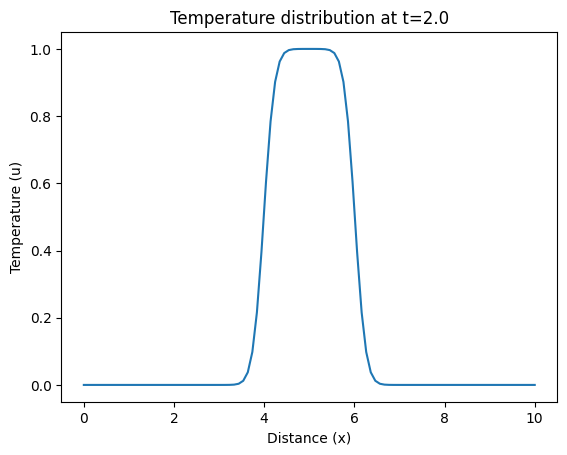

In [67]:
answer = bot(question="Solve heat equation")

In [72]:
answer

array([0.00000000e+00, 1.06501826e-38, 2.57848030e-37, 6.03713557e-36,
       1.36821846e-34, 2.99947520e-33, 6.35609108e-32, 1.30095140e-30,
       2.56985796e-29, 4.89511954e-28, 8.98315243e-27, 1.58666251e-25,
       2.69451802e-24, 4.39478202e-23, 6.87602741e-22, 1.03068949e-20,
       1.47812624e-19, 2.02509189e-18, 2.64624875e-17, 3.29240420e-16,
       3.89286312e-15, 4.36515723e-14, 4.63148896e-13, 4.63818675e-12,
       4.37206476e-11, 3.86731098e-10, 3.19917156e-09, 2.46556479e-08,
       1.76271406e-07, 1.16338494e-06, 7.04916163e-06, 3.89645921e-05,
       1.95051228e-04, 8.76800452e-04, 3.50481889e-03, 1.23171911e-02,
       3.75666687e-02, 9.80204667e-02, 2.15659594e-01, 3.95594770e-01,
       6.04405230e-01, 7.84340406e-01, 9.01979533e-01, 9.62433331e-01,
       9.87682809e-01, 9.96495181e-01, 9.99123196e-01, 9.99804924e-01,
       9.99960859e-01, 9.99991787e-01, 9.99991787e-01, 9.99960859e-01,
       9.99804924e-01, 9.99123196e-01, 9.96495181e-01, 9.87682809e-01,
      

In [71]:
mini.inspect_history()





[2024-10-22T22:46:47.894049]

System message:

Your input fields are:
1. `question` (str): The question to answer

Your output fields are:
1. `reasoning` (str)
2. `code` (str): Python code to answer the question. Store the value in the variable "result". Starts with "```python" and ends with "```"

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## question ## ]]
{question}

[[ ## reasoning ## ]]
{reasoning}

[[ ## code ## ]]
{code}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given the fields `question`, produce the fields `code`.


User message:

[[ ## question ## ]]
Solve heat equation

Respond with the corresponding output fields, starting with the field `reasoning`, then `code`, and then ending with the marker for `completed`.


Response:

[[ ## reasoning ## ]]
The heat equation is a partial differential equation that describes the distribution of heat in a given region over time. It can